In [20]:
# ATSC 500 Project Code 
# Regrid and refine ERA5 and CMIP6 datasets so that they are comparable; find DTR for both
# Mina Deshler

import xarray as xr
xr.set_options(display_style='html')
import intake
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy
import xesmf as xe
import datetime as dt
from datetime import datetime

In [12]:
# Load in all era5 data
df = xr.open_zarr('era5_2.zarr')
df

<xarray.Dataset>
Dimensions:     (time: 994, step: 24, latitude: 113, longitude: 251)
Coordinates:
  * latitude    (latitude) float64 60.0 59.9 59.8 59.7 ... 49.1 49.0 48.9 48.8
  * longitude   (longitude) float64 -139.0 -138.9 -138.8 ... -114.1 -114.0
    number      int32 ...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     float64 ...
  * time        (time) datetime64[ns] 1998-05-31 1998-06-01 ... 2014-08-31
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(994, 24), meta=np.ndarray>
Data variables:
    d2m         (time, step, latitude, longitude) float32 dask.array<chunksize=(125, 3, 29, 63), meta=np.ndarray>
    sshf        (time, step, latitude, longitude) float32 dask.array<chunksize=(125, 3, 29, 63), meta=np.ndarray>
    t2m         (time, step, latitude, longitude) float32 dask.array<chunksize=(125, 3, 29, 63), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-07-27T14:33 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [13]:
# Checking timestamps
datacheck = df.isel(time=32)
datacheck
#Error with mislabeled timestamps for June 2006 - says 1998 for part of this month ?

<xarray.Dataset>
Dimensions:     (step: 24, latitude: 113, longitude: 251)
Coordinates:
  * latitude    (latitude) float64 60.0 59.9 59.8 59.7 ... 49.1 49.0 48.9 48.8
  * longitude   (longitude) float64 -139.0 -138.9 -138.8 ... -114.1 -114.0
    number      int32 ...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     float64 ...
    time        datetime64[ns] 2004-07-01
    valid_time  (step) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
Data variables:
    d2m         (step, latitude, longitude) float32 dask.array<chunksize=(3, 29, 63), meta=np.ndarray>
    sshf        (step, latitude, longitude) float32 dask.array<chunksize=(3, 29, 63), meta=np.ndarray>
    t2m         (step, latitude, longitude) float32 dask.array<chunksize=(3, 29, 63), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-07-27T14:33 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [14]:
# Convert lon values from ERA5 to match CMIP6 lon values:
df.coords['longitude'] = df.coords['longitude'] + 360
df = df.sortby(df.longitude)
df

<xarray.Dataset>
Dimensions:     (time: 994, step: 24, latitude: 113, longitude: 251)
Coordinates:
  * latitude    (latitude) float64 60.0 59.9 59.8 59.7 ... 49.1 49.0 48.9 48.8
    number      int32 ...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     float64 ...
  * time        (time) datetime64[ns] 1998-05-31 1998-06-01 ... 2014-08-31
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(994, 24), meta=np.ndarray>
  * longitude   (longitude) float64 221.0 221.1 221.2 ... 245.8 245.9 246.0
Data variables:
    d2m         (time, step, latitude, longitude) float32 dask.array<chunksize=(125, 3, 29, 63), meta=np.ndarray>
    sshf        (time, step, latitude, longitude) float32 dask.array<chunksize=(125, 3, 29, 63), meta=np.ndarray>
    t2m         (time, step, latitude, longitude) float32 dask.array<chunksize=(125, 3, 29, 63), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-07-27T14:33 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [15]:
# Save only max and min values per day
# Ref: https://docs.xarray.dev/en/latest/user-guide/indexing.html
Tmin = df.t2m.min(dim = "step")
#Tmin = Tmin.rename({'t2m':'Tmin'})
Tmax = df.t2m.max(dim = "step")
SSHFmin = df.sshf.min(dim = "step")
SSHFmax = df.sshf.max(dim = "step")
# Combining to one xarray:
#era5 = xr.merge([Tmin,Tmax,SSHFmin,SSHFmax])
#era5

# DTR for ERA5:
DTR_era = Tmax - Tmin
DTR_era

# Save
DTR_era.load().to_zarr("era5_DTR.zarr")
Tmin.load().to_zarr("era5_Tmin.zarr")
Tmax.load().to_zarr("era5_Tmax.zarr")
SSHFmin.load().to_zarr("era5_SSHFmin.zarr")
SSHFmax.load().to_zarr("era5_SSHFmax.zarr")

In [16]:
Tmin.time

<xarray.DataArray 'time' (time: 994)>
array(['1998-05-31T00:00:00.000000000', '1998-06-01T00:00:00.000000000',
       '1998-06-02T00:00:00.000000000', ..., '2014-08-29T00:00:00.000000000',
       '2014-08-30T00:00:00.000000000', '2014-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number   int32 0
    surface  float64 0.0
  * time     (time) datetime64[ns] 1998-05-31 1998-06-01 ... 2014-08-31
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [91]:
# Load in CMIP6 temperature data
cmiptemps = xr.open_zarr('maxmintemps2.zarr')
# Get DTR for CMIP6 data
cmip_DTR = cmiptemps.tasmax - cmiptemps.tasmin
cmip_DTR
# Save
cmip_DTR.load().to_zarr("cmip_DTR.zarr")

TypeError: expected unicode string, found 1

In [17]:
# Regrid ERA5 data onto the coarser CMIP6 grid 
# Ref: https://xesmf.readthedocs.io/en/latest/notebooks/Dataset.html 
# https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html

# Output grid:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(49.5, 60.5, 1.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(225.625, 245.625, 1.25), {"units": "degrees_east"}),
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (lat: 11, lon: 16)
Coordinates:
  * lat      (lat) float64 49.5 50.5 51.5 52.5 53.5 ... 55.5 56.5 57.5 58.5 59.5
  * lon      (lon) float64 225.6 226.9 228.1 229.4 ... 240.6 241.9 243.1 244.4
Data variables:
    *empty*

In [18]:
# Regridder
regridder = xe.Regridder(df, ds_out, "conservative")
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_113x251_11x16.nc 
Reuse pre-computed weights? False 
Input grid shape:           (113, 251) 
Output grid shape:          (11, 16) 
Periodic in longitude?      False

In [19]:
tmin_regrid = regridder(Tmin, keep_attrs=True)
tmax_regrid = regridder(Tmax, keep_attrs=True)
fluxmin_regrid = regridder(SSHFmin, keep_attrs=True)
fluxmax_regrid = regridder(SSHFmax, keep_attrs=True)
# Solve for DTR based on regridded data (not average of original DTR)
DTR_regrid = tmax_regrid - tmin_regrid

# Save
DTR_regrid.load().to_zarr("era5_DTR_regrid.zarr")
tmin_regrid.load().to_zarr("era5_Tmin_regrid.zarr")
tmax_regrid.load().to_zarr("era5_Tmax_regrid.zarr")
fluxmin_regrid.load().to_zarr("era5_SSHFmin_regrid.zarr")
fluxmax_regrid.load().to_zarr("era5_SSHFmax_regrid.zarr")

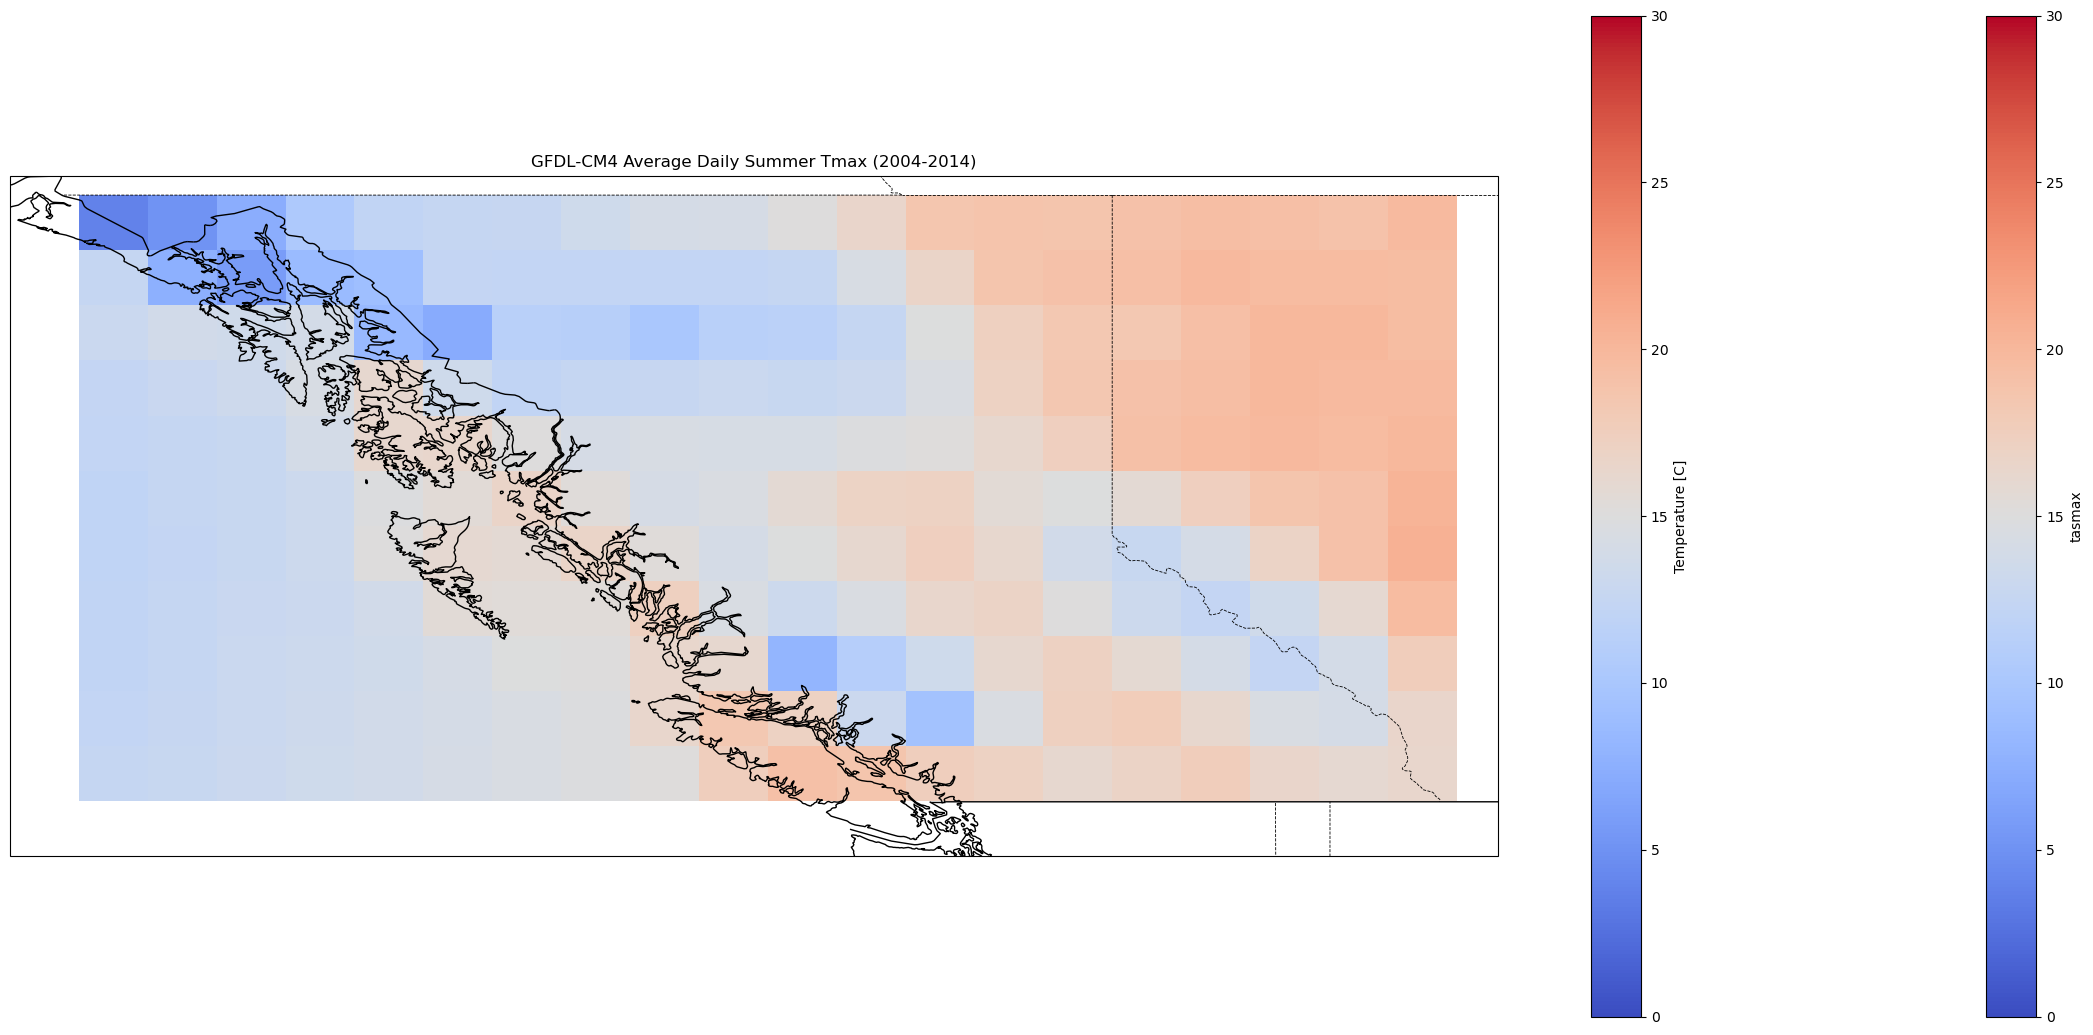

In [142]:
# Plot average Tmax for CMIP6 for entire data period 
cmipdata = cmiptemps.mean('time') - 273.15 #Average for entire data period, Kelvin to Celcius
#precip_data2010 = precip_data2010.mean('member_id')

fig = plt.figure(1, figsize=[30,13])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-140, -113, 48, 60])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)



m = cmipdata.tasmax.plot(ax=ax,cmap='coolwarm',vmin = 0, vmax = 30, label = 'Temperature [C]')
plt.colorbar(m,label = 'Temperature [C]')
ax.title.set_text("GFDL-CM4 Average Daily Summer Tmax (2004-2014)")

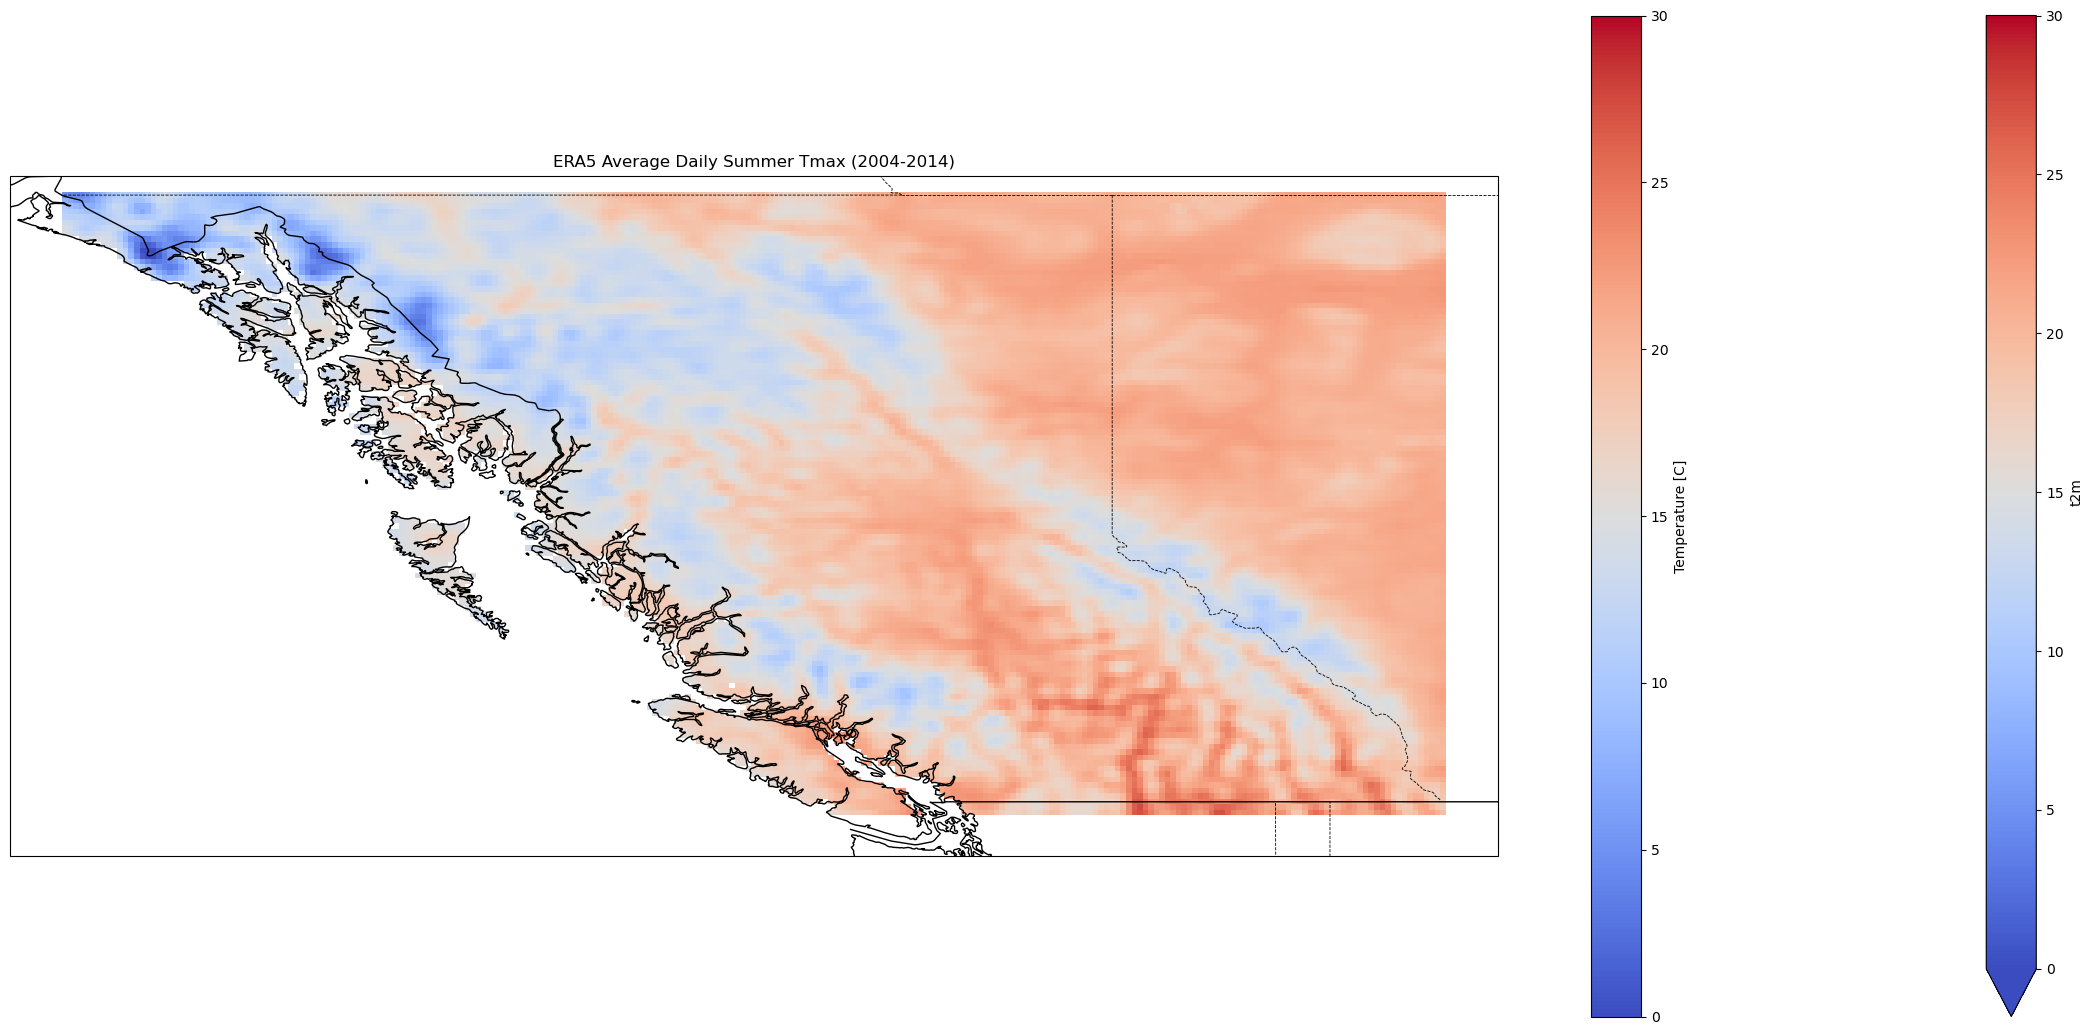

In [143]:
# Plot ERA5 before regrid, average Tmax for entire data period 
#data2010 = Tmin.sel(time='2010')
precip_data2010 = Tmax.mean('time') - 273.15
#precip_data2010 = precip_data2010.mean('member_id')

fig = plt.figure(1, figsize=[30,13])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-140, -113, 48, 60])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)



m = precip_data2010.plot(ax=ax,cmap='coolwarm',vmin = 0, vmax = 30)
plt.colorbar(m,label = 'Temperature [C]')
ax.title.set_text("ERA5 Average Daily Summer Tmax (2004-2014)")

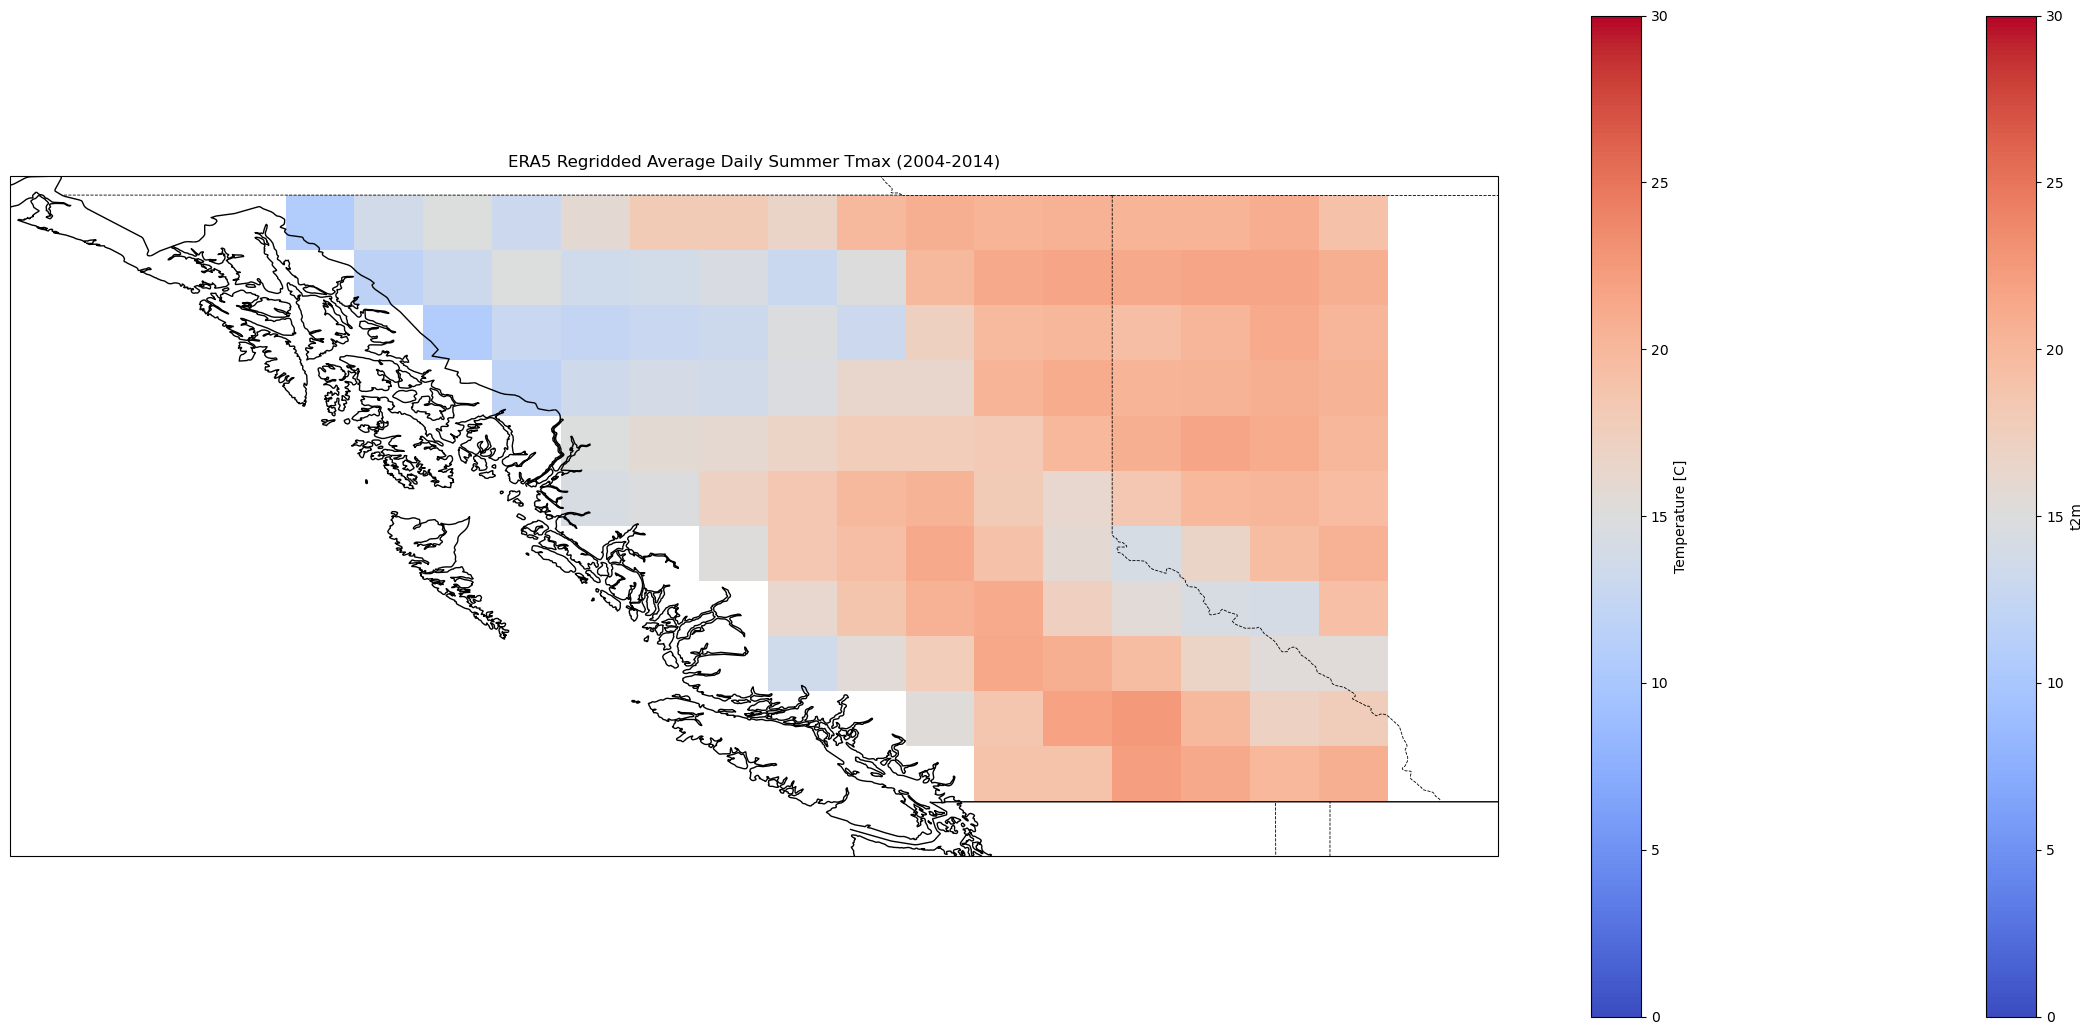

In [144]:
# Plot ERA5 after regrid, average Tmax for entire data period 
precip_data2010 = tmax_regrid.mean('time') - 273.15
#precip_data2010 = precip_data2010.mean('member_id')

fig = plt.figure(1, figsize=[30,13])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-140, -113, 48, 60])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)



m = precip_data2010.plot(ax=ax,cmap='coolwarm',vmin = 0, vmax = 30)
plt.colorbar(m,label = 'Temperature [C]')
ax.title.set_text("ERA5 Regridded Average Daily Summer Tmax (2004-2014)")

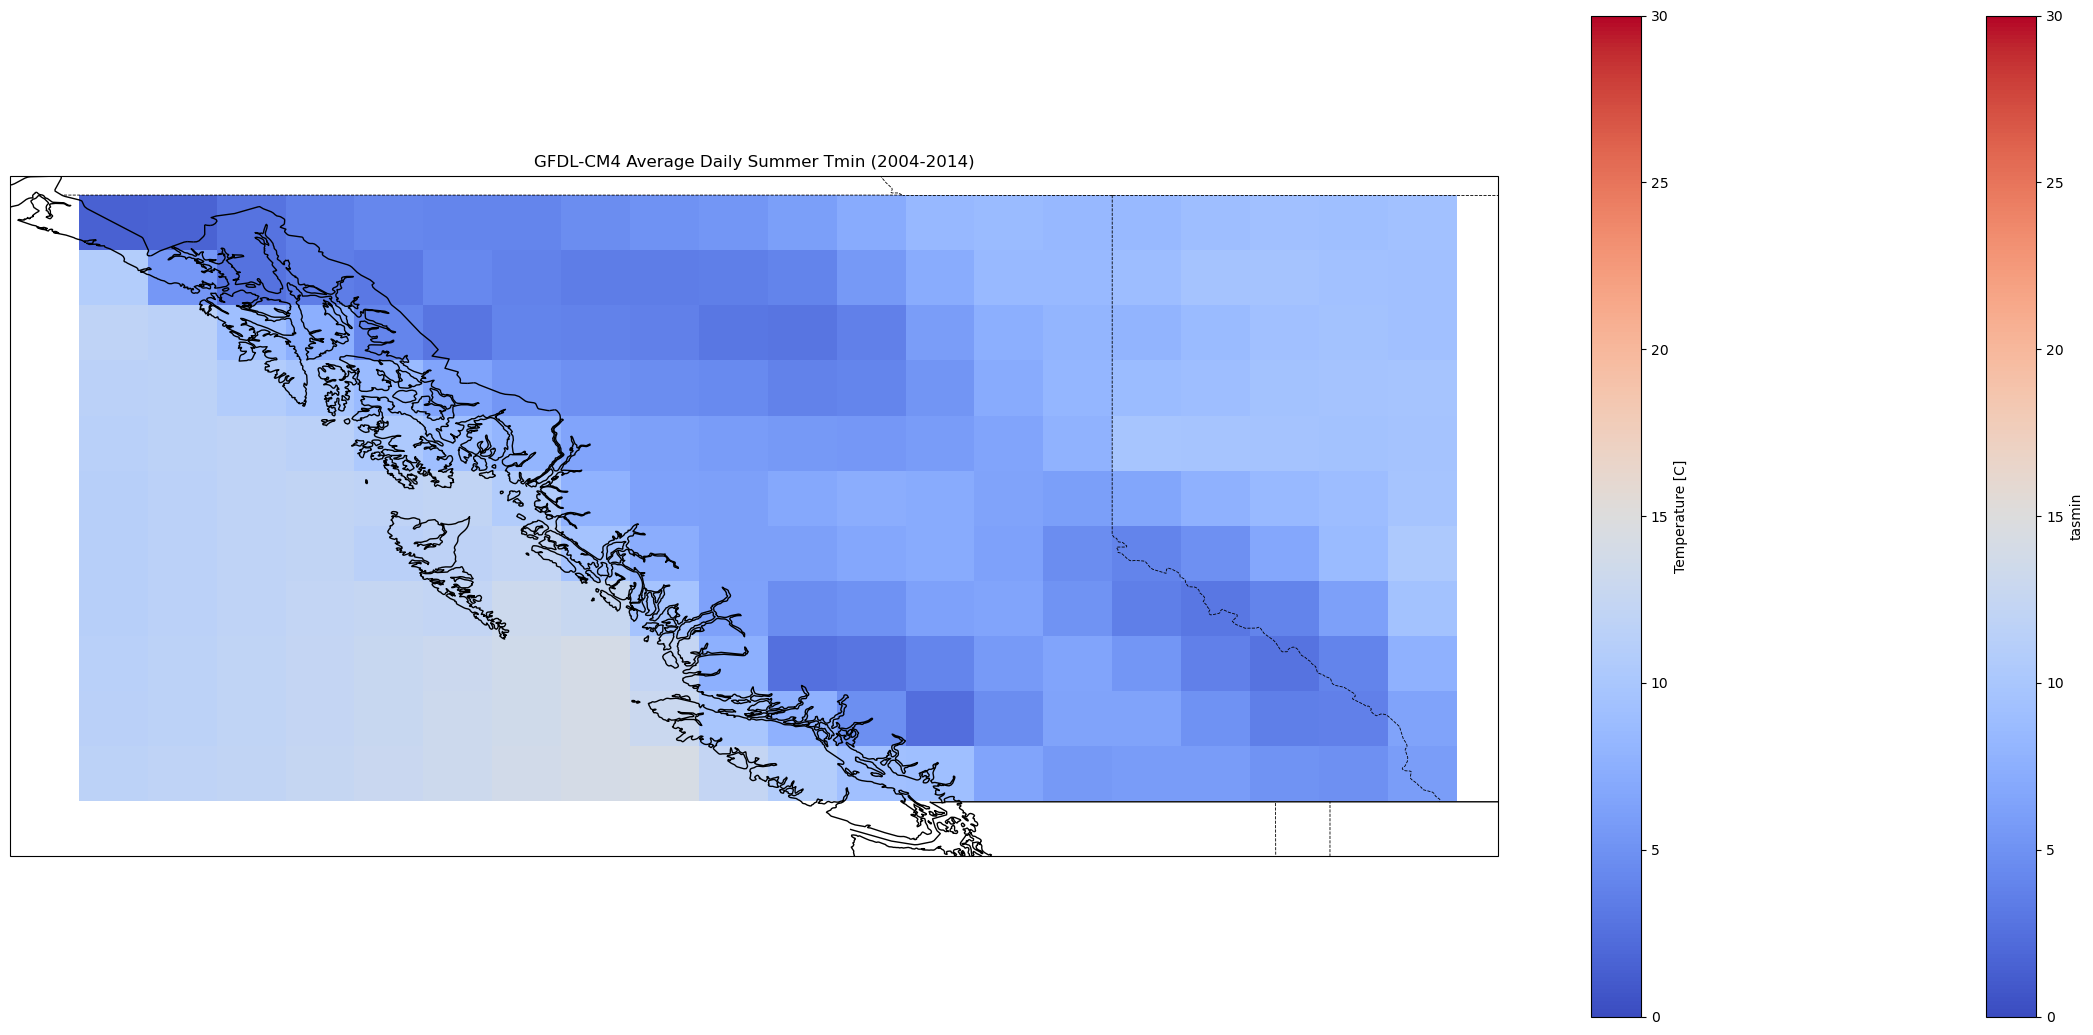

In [145]:
# Plot average Tmin for CMIP6 for entire data period 
cmipdata = cmiptemps.mean('time') - 273.15 #Average for entire data period, Kelvin to Celcius
#precip_data2010 = precip_data2010.mean('member_id')

fig = plt.figure(1, figsize=[30,13])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-140, -113, 48, 60])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)



m = cmipdata.tasmin.plot(ax=ax,cmap='coolwarm',vmin = 0, vmax = 30)
plt.colorbar(m,label = 'Temperature [C]')
ax.title.set_text("GFDL-CM4 Average Daily Summer Tmin (2004-2014)")

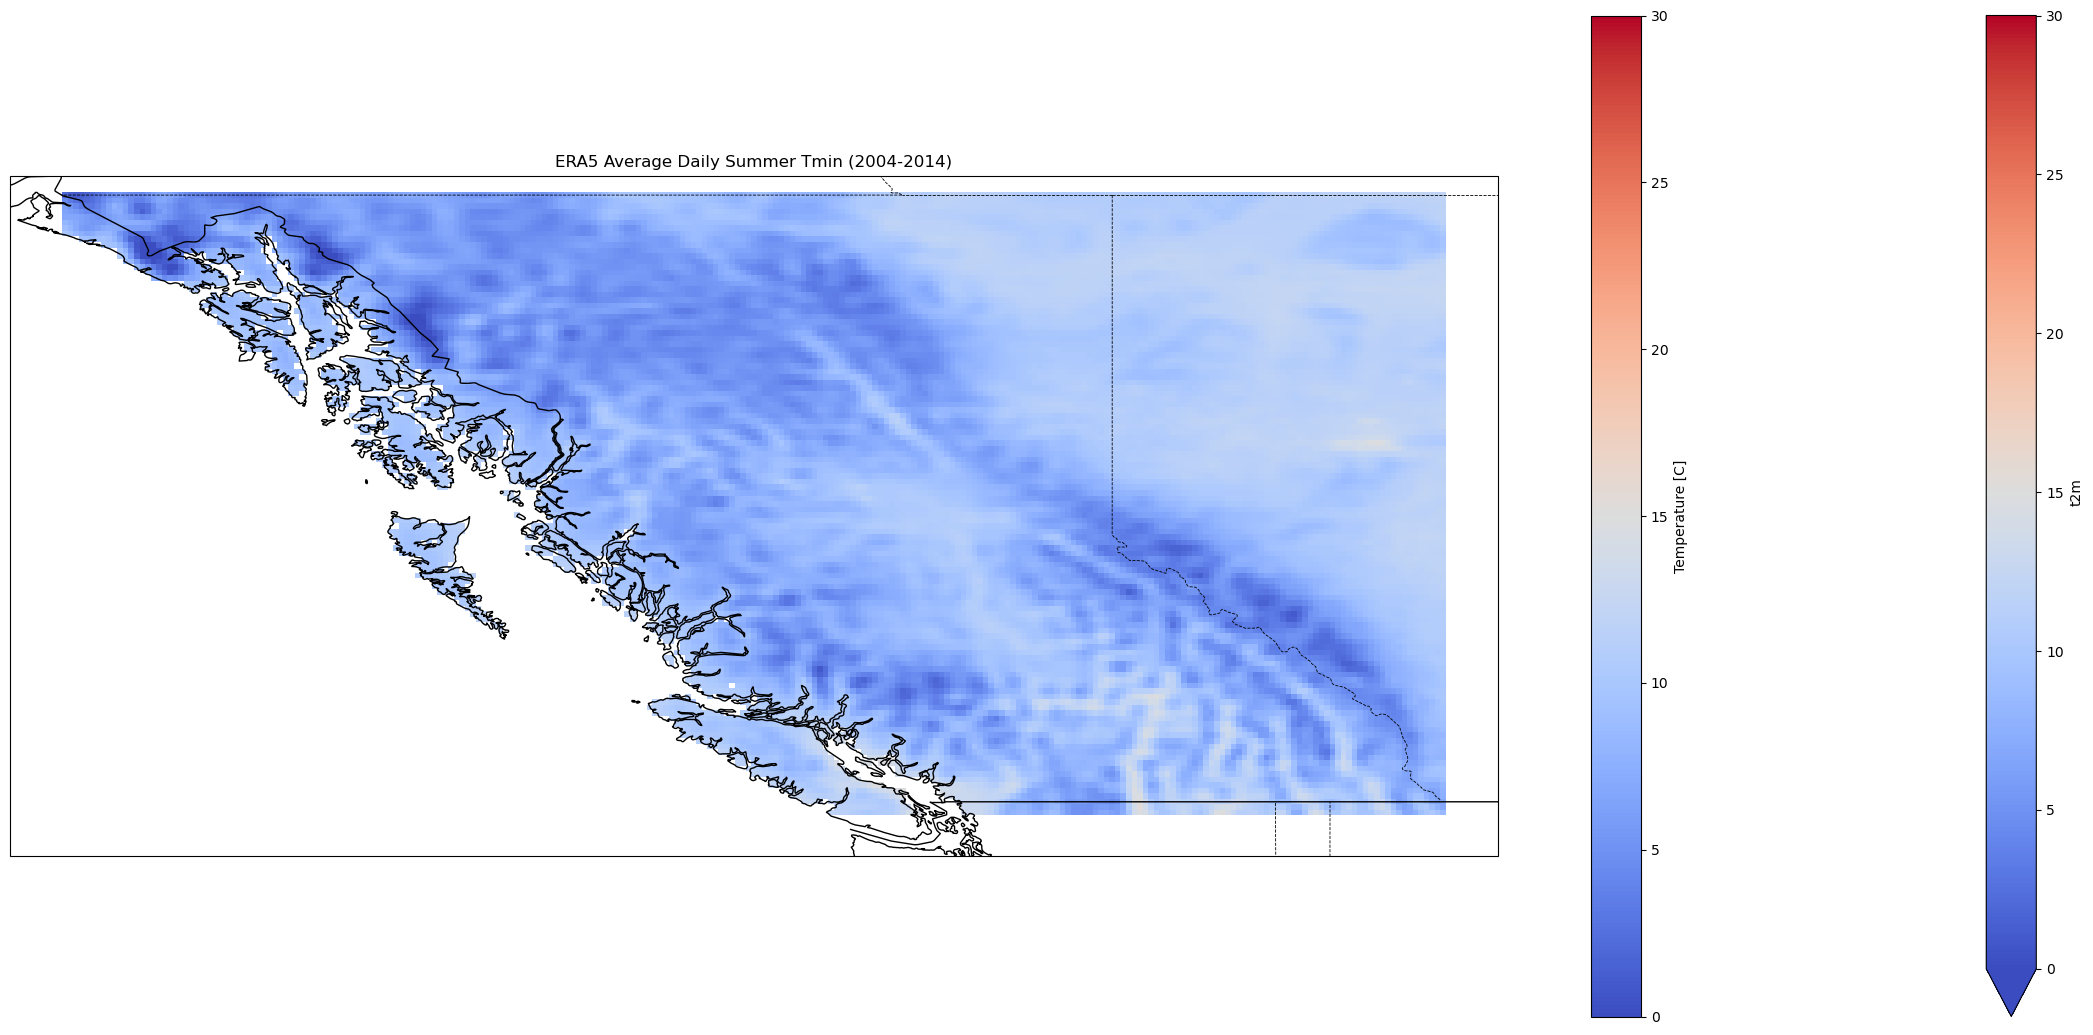

In [146]:
# Plot ERA5 before regrid, average Tmin for entire data period 
precip_data2010 = Tmin.mean('time') - 273.15
#precip_data2010 = precip_data2010.mean('member_id')

fig = plt.figure(1, figsize=[30,13])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-140, -113, 48, 60])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)



m = precip_data2010.plot(ax=ax,cmap='coolwarm',vmin = 0, vmax = 30)
plt.colorbar(m,label = 'Temperature [C]')
ax.title.set_text("ERA5 Average Daily Summer Tmin (2004-2014)")